# Stats Gde dimension : Projet (3) : DataChallenge

https://challengedata.ens.fr/participants/challenges/67/

Voici la démarche que nous avons adopté pour répondre au problème :



Nous allons commencé en partie par explorer et traiter les données :


<b>- <u>Partie I : Traiter les données</u></b>

I-a) Importation et observation des données,

I-b) Traiter les données et séparer en deux jeux : un jeu d'entrainement et un jeu de validation,

I-c) Extraction des données de validation ('X_test_surge_new.npz' fourni par DataChallenge, à prédir)




Dans la partie suivante, nous allons tester différentes méthodes et les comparer sur le jeu de test :

<b>- <u>Partie II : Prévisions à l'aide de différentes méthodes</u></b>

II-a) Méthode n°1 : K-plus proches voisins (KNN)

II-b) Méthode n°2 : Decision Tree

II-c) Méthode n°3 : Random Forest

II-d) Méthode n°4 : Réseaux de Neurones

II-e) Méthode n°5 : Regression Lasso, PLS, ...



Enfin, après avoir choisi une méthode, nous allons entrainer notre meilleur modèle et prédir les données à prédir :

<b>- <u>Partie III : Application de notre "meilleure méthode"</u></b>

Choix d'une méthode parmis les méthodes testées précédemment, entrainement sur le jeu entier de données 'X_train_complet' puis recherche des 'y_test'.

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import time
import os

import plotly.express as px
import random
import numpy.random as npr
from sklearn.model_selection import train_test_split

dossier = 'D:/DocDataM2/S3UE1_Datachallenge/'
os.chdir(dossier)

## <b><u>Partie I : Traiter les données</b></u>


## I-a) <u>Importation et observation des données</u>


Explorons les données avant de les traiter

In [2]:
# On import le fichier d'entrainement original
X_npz = np.load('X_train_surge_new.npz')

In [5]:
for cle in X_npz:
    print( type(X_npz[cle]), '  ', cle, '\t\t', X_npz[cle].shape )

cles = list(X_npz.keys())
print()
print(cles)

<class 'numpy.ndarray'>    id_sequence 		 (5599,)
<class 'numpy.ndarray'>    t_slp 		 (5599, 40)
<class 'numpy.ndarray'>    slp 		 (5599, 40, 41, 41)
<class 'numpy.ndarray'>    t_surge1_input 		 (5599, 10)
<class 'numpy.ndarray'>    surge1_input 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge2_input 		 (5599, 10)
<class 'numpy.ndarray'>    surge2_input 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge1_output 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge2_output 		 (5599, 10)

['id_sequence', 't_slp', 'slp', 't_surge1_input', 'surge1_input', 't_surge2_input', 'surge2_input', 't_surge1_output', 't_surge2_output']


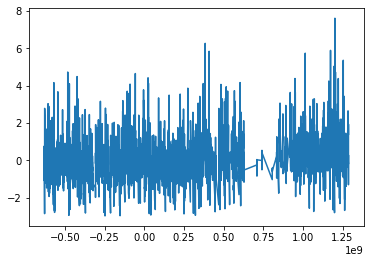

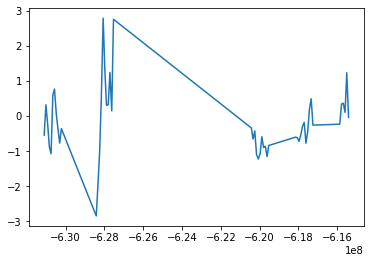

In [9]:
plt.plot(X_npz['t_surge1_input'][:,0],X_npz['surge1_input'][:,0])  
    # Chaque ligne (ici i=0) correspond à un jour
    # chaque colonne correspond à 1 heure précise, chaque jour
plt.show()

plt.plot(X_npz['t_surge1_input'][:50,0],X_npz['surge1_input'][:50,0])  
    # Chaque ligne (ici i=0) correspond à un jour
    # chaque colonne correspond à 1 heure précise, chaque jour
plt.show()

(5599, 40, 41, 41)


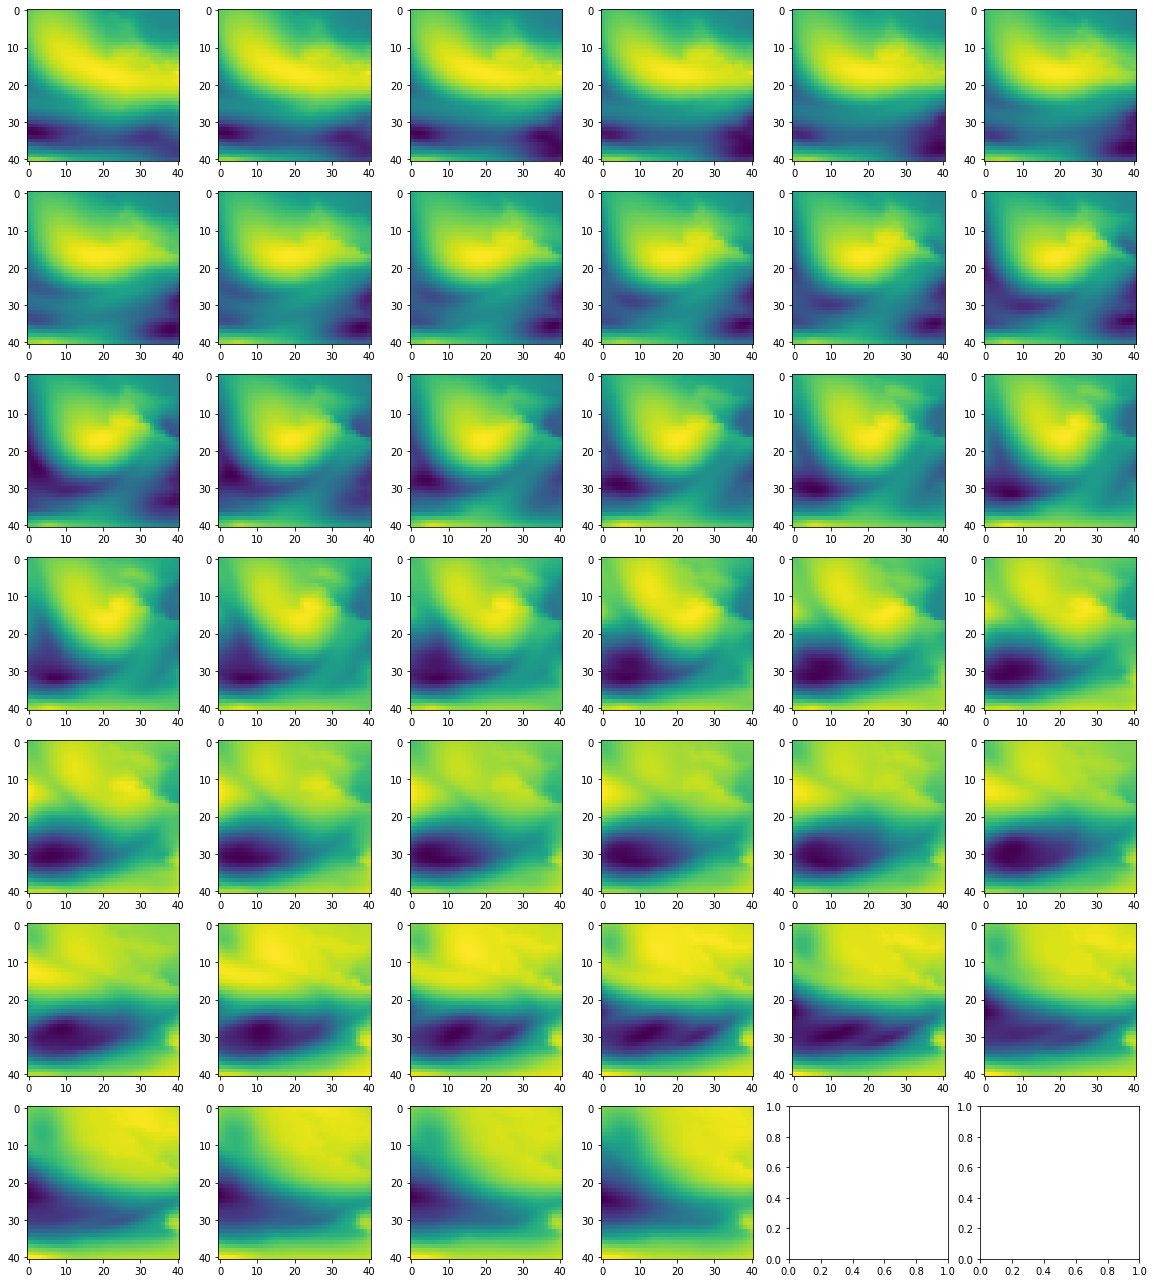

In [11]:
print(X_npz['slp'].shape)

fig = plt.figure(figsize=(20,23))

axs = fig.subplots(7,6)

ligne = 0

for k in range(40):
    image = X_npz['slp'][ligne, k, :, : ]     # Une image
    axs[k//6,k%6].imshow(image)
    
    # Enregistrement image par image :
    #plt.imshow(image)                       # 
    #plt.savefig(f"C:/Users/kevin/Documents/GitHub/M2_DataChallenge/images/tests/ligne_{ligne}_k_{k}")
#plt.savefig(f"C:/Users/kevin/Documents/GitHub/M2_DataChallenge/images/tests/ligne_{ligne}")

## I-b) <u>Séparer les données et en deux jeux : un jeu d'entrainement et un jeu de validation</u>


On sépare les données originales en un set d'entrainement <b>df_train</b> et un set de validation <b>df_valid</b>,

60 % des données serviront à l'entrainement (taux = 0.6).

In [4]:
##### choix des données d'entrainement  : #####
taux = 0.6

slice_train = np.bool_(npr.binomial(1,taux,5599))
k_train = range(5599)*slice_train

print('Train :')
print(slice_train[:10])
print(k_train[:10])
n_train = sum(slice_train)

k_train.sort()
k_train = k_train[5599-n_train:]  # on enlève tous les zeros
print(k_train)


##### choix des données de valid  : #####
slice_valid = ~slice_train
k_valid = range(5599)*slice_valid

print('valid :')
print(slice_valid[:10])
print(k_valid[:10])
n_valid = 5599 - n_train

k_valid.sort()
k_valid = k_valid[5599-n_valid:]  # on enlève tous les zeros
print(k_valid)


Train :
[False False False  True False False  True  True False False]
[0 0 0 3 0 0 6 7 0 0]
[   3    6    7 ... 5594 5596 5597]
valid :
[ True  True  True False  True  True False False  True  True]
[0 1 2 0 4 5 0 0 8 9]
[   0    1    2 ... 5593 5595 5598]


### Transformer les données en df :


In [5]:
# Création d'un df vide
df_train = pd.DataFrame(index = range(n_train))

# On commence par construire un df qui contient la première valeurs des listes t_spl
df_train[f't_slp_begin'] = list(X_npz['t_slp'][slice_train][:,0])
df_train.head(5)

##### Même chose avec les données de validation #####
df_valid = pd.DataFrame(index = range(n_valid))
df_valid[f't_slp_begin'] = list(X_npz['t_slp'][slice_valid][:,0])
df_valid

,t_slp_begin
0,-6.310764e+08
1,-6.309792e+08
2,-6.308928e+08
3,-6.307200e+08
4,-6.306228e+08
...,...
2219,1.285459e+09
2220,1.287036e+09
2221,1.287392e+09
2222,1.287565e+09


In [6]:
# on ajoute les image slp

# selection des slp (sur les 40 pas de temps disponibles)
which_slp = [0, 1, 2, 3, 6, 10, 15, 20, 25, 30, 35]   # 40 valeurs de 0 à 39

# pas de moyennisation de pixels (prendre une moyenne de pixels / pas, et ignorer les autres) (image 41x41)
pas = 4

print("Traitement des données d'entrainement :")
data_train =  X_npz['slp'][slice_train]
for k in which_slp:
    print(k, end=' ; ')
    #print(X_npz['slp'].shape)
    #print(X_npz['slp'][slice_train][:,k,:,:].shape)
    for i in range(41//pas):

        for j in range(41//pas):
            
            # liste pour chaque ligne des valeurs du pixels (i,j) pour la date k

            # Moyennisation
            pxs_moyen = 0
            for abss in range(pas):
                for ordd in range(pas):
                    pixel = data_train[:,k,i*pas+abss,j*pas+ordd]
                    pxs_moyen += pixel
            pxs_moyen /=(pas**2)
            pxs_moyen /= 100000

            df_temp = pd.DataFrame(pxs_moyen, columns=[f"slp{k}_x_{i*pas}_y_{j*pas}"] ) 
            
            # Ajout de la colonne au df
            df_train = pd.concat([df_train, df_temp], axis=1)

#print()
#print(df_train.head(5))


##### Même chose avec les données de validation #####
print("\nTraitement des données de validation :")
data_valid =  X_npz['slp'][slice_valid]
for k in which_slp:
    
    print(k, end=' ; ')
    for i in range(41//pas):
        for j in range(41//pas):
            pxs_moyen = 0
            for abss in range(pas):
                for ordd in range(pas):
                    pixel = data_valid[:,k,i*pas+abss,j*pas+ordd]
                    pxs_moyen += pixel
            pxs_moyen /=(pas**2)
            pxs_moyen /= 100000

            df_temp = pd.DataFrame(pxs_moyen, columns=[f"slp{k}_x_{i*pas}_y_{j*pas}"] ) 
            df_valid = pd.concat([df_valid, df_temp], axis=1)

print()
df_valid.head(5)

Traitement des données d'entrainement :
0 ; 1 ; 2 ; 3 ; 6 ; 10 ; 15 ; 20 ; 25 ; 30 ; 35 ; 
Traitement des données de validation :
0 ; 1 ; 2 ; 3 ; 6 ; 10 ; 15 ; 20 ; 25 ; 30 ; 35 ; 


,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_4,slp0_x_0_y_8,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,...,slp35_x_36_y_0,slp35_x_36_y_4,slp35_x_36_y_8,slp35_x_36_y_12,slp35_x_36_y_16,slp35_x_36_y_20,slp35_x_36_y_24,slp35_x_36_y_28,slp35_x_36_y_32,slp35_x_36_y_36
0,-631076416.0,1.025537,1.026974,1.026185,1.023688,1.020092,1.017873,1.017138,1.015019,1.013081,...,1.007829,1.006347,1.005615,1.006098,1.007034,1.008172,1.009343,1.010340,1.011384,1.012856
1,-630979200.0,1.019869,1.021717,1.021607,1.020457,1.019034,1.018357,1.019126,1.017700,1.016491,...,1.013321,1.012065,1.010692,1.009337,1.008012,1.006794,1.005237,1.004281,1.005149,1.008071
2,-630892800.0,1.017251,1.019911,1.021260,1.021207,1.019921,1.018681,1.018545,1.017563,1.015939,...,1.009374,1.009143,1.009853,1.012221,1.014059,1.014636,1.013996,1.012068,1.008961,1.005685
3,-630720000.0,1.011215,1.013787,1.017968,1.019858,1.020021,1.019869,1.019771,1.019589,1.018909,...,1.001989,0.999366,0.996967,0.996321,0.997168,0.999128,1.002111,1.005916,1.010922,1.017324
4,-630622784.0,1.004607,1.004016,1.004701,1.009063,1.013247,1.016639,1.019374,1.020586,1.020859,...,0.994216,0.992399,0.991514,0.992164,0.994426,0.997300,0.999913,1.001998,1.003813,1.006106


In [7]:
df_train

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_4,slp0_x_0_y_8,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,...,slp35_x_36_y_0,slp35_x_36_y_4,slp35_x_36_y_8,slp35_x_36_y_12,slp35_x_36_y_16,slp35_x_36_y_20,slp35_x_36_y_24,slp35_x_36_y_28,slp35_x_36_y_32,slp35_x_36_y_36
0,-6.308064e+08,1.014756,1.017956,1.020476,1.020881,1.019801,1.019045,1.018436,1.017728,1.015910,...,1.008115,1.007100,1.007172,1.009045,1.011787,1.014712,1.016852,1.017889,1.018643,1.020401
1,-6.305364e+08,1.009572,1.007498,1.006012,1.006370,1.010621,1.016128,1.019925,1.021344,1.022531,...,1.002601,1.001394,0.999794,0.996371,0.992426,0.989100,0.987424,0.988403,0.991419,0.995502
2,-6.304392e+08,1.020039,1.021021,1.021258,1.020813,1.019946,1.019819,1.019740,1.020425,1.020709,...,1.005617,1.002586,0.999118,0.994723,0.991529,0.990620,0.991444,0.993197,0.995411,0.997886
3,-6.301800e+08,1.022992,1.022427,1.022816,1.022528,1.021569,1.021706,1.023507,1.021214,1.018807,...,1.020285,1.021443,1.022256,1.021779,1.020084,1.017928,1.014813,1.011616,1.009053,1.008036
4,-6.282144e+08,1.027633,1.026980,1.025937,1.024962,1.024684,1.025052,1.023895,1.023780,1.023934,...,1.004912,1.002649,0.998890,0.994557,0.992677,0.992611,0.993420,0.994581,0.995742,0.996275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370,1.287209e+09,1.011087,1.012638,1.011193,1.008632,1.010697,1.011617,1.009551,1.008420,1.008110,...,1.021101,1.020082,1.018951,1.014988,1.008509,1.001948,0.997491,0.996670,0.998358,1.000043
3371,1.287306e+09,1.011442,1.013052,1.014733,1.013991,1.014154,1.014188,1.012298,1.011384,1.010902,...,1.023357,1.022920,1.021487,1.018257,1.012305,1.004149,0.998529,0.998028,0.997391,0.996767
3372,1.287479e+09,1.014474,1.014945,1.015893,1.016402,1.015274,1.013968,1.013924,1.015074,1.016419,...,1.026416,1.026002,1.024717,1.022104,1.017903,1.013347,1.008785,1.004105,0.999569,0.995638
3373,1.287652e+09,1.018808,1.017131,1.016581,1.017201,1.016651,1.015574,1.016440,1.017401,1.018641,...,1.011475,1.011579,1.012237,1.014039,1.016073,1.016847,1.016333,1.015379,1.014016,1.011851


In [8]:
# TRAITEMENT DES t_surgeX et surge_X

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print("Traitement des données d'entrainement :")


# On ajoute les 't_surgeX_input' (en ne gardant que la première valeur)
liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_train[feature] = list(X_npz[feature][slice_train][:,0])


# puis on ajoute les 'surgeX_input' (tous)
liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_train[f"{feature}_{k}"] = list(X_npz[feature][slice_train][:,k])


##### Même chose avec les données de validation #####
print("\nTraitement des données de validation :")

liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_valid[feature] = list(X_npz[feature][slice_valid][:,0])

liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_valid[f"{feature}_{k}"] = list(X_npz[feature][slice_valid][:,k])



Traitement des données d'entrainement :
surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
Traitement des données de validation :
surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 

In [10]:
# traitement des t_surgeX_output

for k in [1,2]:
    df_train[f't_surge{k}_output'] = X_npz[f't_surge{k}_output'][slice_train][:,0]
    df_valid[f't_surge{k}_output'] = X_npz[f't_surge{k}_output'][slice_valid][:,0]

In [11]:
df_train.head(2)

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_4,slp0_x_0_y_8,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,...,surge2_input_2,surge2_input_3,surge2_input_4,surge2_input_5,surge2_input_6,surge2_input_7,surge2_input_8,surge2_input_9,t_surge1_output,t_surge2_output
0,-631076416.0,1.025537,1.026974,1.026185,1.023688,1.020092,1.017873,1.017138,1.015019,1.013081,...,-1.202260,-1.193878,-1.143584,-0.816675,-0.757999,-0.129327,-0.179620,-0.372413,-630662400.0,-630658816.0
1,-630979200.0,1.019869,1.021717,1.021607,1.020457,1.019034,1.018357,1.019126,1.017700,1.016491,...,-1.143584,-0.816675,-0.757999,-0.129327,-0.179620,-0.372413,-0.053886,0.356847,-630576000.0,-630568832.0


In [13]:
df_train.columns

Index(['t_slp_begin', 'slp0_x_0_y_0', 'slp0_x_0_y_4', 'slp0_x_0_y_8',
       'slp0_x_0_y_12', 'slp0_x_0_y_16', 'slp0_x_0_y_20', 'slp0_x_0_y_24',
       'slp0_x_0_y_28', 'slp0_x_0_y_32',
       ...
       'surge2_input_2', 'surge2_input_3', 'surge2_input_4', 'surge2_input_5',
       'surge2_input_6', 'surge2_input_7', 'surge2_input_8', 'surge2_input_9',
       't_surge1_output', 't_surge2_output'],
      dtype='object', length=1125)

In [14]:
# Prend quelques minutes
"""
df_train.to_csv('export_X_train.csv')  # je n'obtiens pas ce que je veux (les données obtenus sont des chaines de caractères)
df_valid.to_csv('export_X_valid.csv')
"""

"\ndf_train.to_csv('export_X_train.csv')  # je n'obtiens pas ce que je veux (les données obtenus sont des chaines de caractères)\ndf_valid.to_csv('export_X_valid.csv')\n"

In [15]:
# Création des variables d'entrées X pour chacune des villes 1 et 2:

colonnes_unique_1 = ['t_surge1_input', 't_surge1_output']+[f'surge1_input_{k}' for k in range(10)]
colonnes_unique_2 = ['t_surge2_input', 't_surge1_output']+[f'surge2_input_{k}' for k in range(10)]

X_train_1 = df_train[df_train.columns.difference(colonnes_unique_2)]
X_train_2 = df_train[df_train.columns.difference(colonnes_unique_1)]

X_train_1.head(3)

##### Même chose avec les données de valid #####
X_valid_1 = df_valid[df_valid.columns.difference(colonnes_unique_2)]
X_valid_2 = df_valid[df_valid.columns.difference(colonnes_unique_1)]

X_valid_1.head(3)

,slp0_x_0_y_0,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,slp0_x_0_y_36,slp0_x_0_y_4,slp0_x_0_y_8,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,1.025537,1.023688,1.020092,1.017873,1.017138,1.015019,1.013081,1.012637,1.026974,1.026185,...,0.194787,-0.227526,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,-631076416.0,-631108800.0,-630658816.0
1,1.019869,1.020457,1.019034,1.018357,1.019126,1.017700,1.016491,1.015284,1.021717,1.021607,...,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,0.586936,1.069580,-630979200.0,-631018816.0,-630568832.0
2,1.017251,1.021207,1.019921,1.018681,1.018545,1.017563,1.015939,1.014302,1.019911,1.021260,...,-0.639785,-1.075506,-1.712328,0.586936,1.069580,0.767928,-0.100162,-630892800.0,-630928768.0,-630482432.0


### Récuperer 'Y_train_surge.csv' et partage en Y_train et Y_valid :

In [18]:
Y = pd.read_csv(dossier + 'Y_train_surge.csv')
print(len(Y))

"""
for cle in Y:
    print( type(Y[cle]), '\t', cle, '\t', Y[cle].shape)
"""
Y

5599


,id_sequence,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,...,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,1,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,...,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057
1,2,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,...,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703
2,3,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,...,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733
3,4,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,...,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707
4,5,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,...,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707,-0.473001,-0.531677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5594,5595,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,1.662831,...,0.759197,0.884931,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700
5595,5596,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,1.662831,1.528763,1.284089,...,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223
5596,5597,0.483033,0.533309,1.448322,1.820360,1.662831,1.528763,1.284089,0.070775,0.888589,...,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223,1.446545,2.670360
5597,5598,1.448322,1.820360,1.662831,1.528763,1.284089,0.070775,0.888589,1.545521,1.166779,...,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223,1.446545,2.670360,2.620066,2.678742


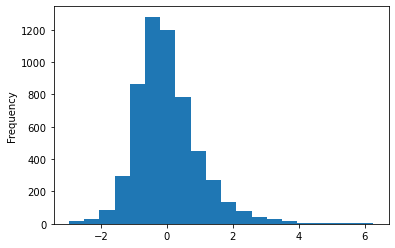

In [17]:
Y['surge1_t0'].plot(kind='hist', bins=20 )
plt.show()

In [19]:
# Création des variables de sortie Y : 
# 40 listes de la forme Y_{TYPE}_{i}_{j}
#       Y_train_1_0 à Y_train_2_9
# ainsi que :
#       Y_valid_1_0 à Y_valid_2_9

for TYPE in ['train', 'valid']:
    print("TYPE :")
    for i in [1,2]:                 # Parcours des lieux à prédir
        print("\tLieux", i, end=" : ")
        for j in range(10):         # Parcours des pas de temps à prédir   
            print(j, end = " ; ") 
            exec(f"Y_{TYPE}_{i}_{j} = list(Y['surge{i}_t{j}'][slice_{TYPE}])")
        print()

Y_train_1_1[:5]

TYPE :
	Lieux 1 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
	Lieux 2 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
TYPE :
	Lieux 1 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
	Lieux 2 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 


[-0.9280309736601846,
 -0.7269291741070817,
 1.160076045032867,
 -1.3067726961518618,
 1.6896441171893717]

In [20]:
len(Y_train_1_1)

3375

In [69]:
## Mesure de la qualité de la prédicition

def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

## I-c) <u>Extraction des données de validation (jeu de 'valid' fourni par DataChallenge, à prédir) PARTIE DEPLACEE EN FIN</u>
 

## <b><u>Partie II : Prévisions à l'aide de différentes méthodes</u></b>


## II-a) <u>Méthode n°1 : K-plus proches voisins (KNN)</u>


In [22]:
## Un premier essai de prédiction et mesure :

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV


# Choix du classifier
#knn = KNeighborsClassifier(2)
"""
SANS standard scaler            Avec standard scaler
K_n = 2         K_n = 10        
0.5789          0.6478          0.6031                  0.57
0.616           0.6701          0.659                   0.6272
0.5832          0.6642          0.6623                  0.6385
0.6144
0.58
0.5941
0.5818
0.605
0.5803
0.5924          0.6374
"""

KNR = KNeighborsRegressor(n_neighbors=10)


for k in range(10):
    # Ajustement sur les données d'entrainement
    KNR.fit(X_train_1_standard, eval(f"Y_train_1_{k}"))
    # Prévision sur les données de valid
    Y_pred = KNR.predict(X_valid_1_standard)
    print(round(np.sum(np.abs(eval(f"Y_valid_1_{k}") - Y_pred))/n_valid,4))


NameError: name 'X_train_1_standard' is not defined

In [26]:
# CV
parameters = {'n_neighbors':range(1,100,1)}      #range(1, 25)}

KNR = KNeighborsRegressor()
clf = GridSearchCV(KNR, parameters, scoring='neg_mean_absolute_error', cv=5, verbose = 3)   
# scoring = neg_mean_absolute_error     or  neg_mean_squared_error


clf.fit(X_train_1, Y_train_1_1)

# 8 mins

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ....................n_neighbors=1;, score=-0.720 total time=   0.5s
[CV 2/5] END ....................n_neighbors=1;, score=-0.796 total time=   0.5s
[CV 3/5] END ....................n_neighbors=1;, score=-1.469 total time=   0.6s
[CV 4/5] END ....................n_neighbors=1;, score=-0.728 total time=   0.3s
[CV 5/5] END ....................n_neighbors=1;, score=-0.840 total time=   0.3s
[CV 1/5] END ....................n_neighbors=2;, score=-0.664 total time=   0.3s
[CV 2/5] END ....................n_neighbors=2;, score=-0.851 total time=   0.4s
[CV 3/5] END ....................n_neighbors=2;, score=-0.874 total time=   0.3s
[CV 4/5] END ....................n_neighbors=2;, score=-0.728 total time=   0.4s
[CV 5/5] END ....................n_neighbors=2;, score=-0.751 total time=   0.2s
[CV 1/5] END ....................n_neighbors=3;, score=-0.704 total time=   0.1s
[CV 2/5] END ....................n_neighbors=3;

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 100)},
             scoring='neg_mean_absolute_error', verbose=3)

In [28]:
print("meilleurs paramètres :", clf.best_params_)
print("meilleurs score (MAE) :", -clf.best_score_)
pred = clf.best_estimator_.predict(X_valid_1) 
MAE_valid = np.sum(np.abs(pred - Y_valid_1_1))/n_valid
print("Score de validation (MAE) :", MAE_valid)


meilleurs paramètres : {'n_neighbors': 68}
meilleurs score (MAE) : 0.7266264549607713
Score de validation (MAE) : 0.7027094938995766



## II-b) <u>Méthode n°2 : Decision Tree</u>


In [21]:
# Importation des packages
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Importation des données
from sklearn.datasets import load_boston

"""
dict_data = load_boston()
data_boston = pd.DataFrame(dict_data['data'], columns = dict_data['feature_names'])
y = dict_data['target']

data_boston.head()
"""


"\ndict_data = load_boston()\ndata_boston = pd.DataFrame(dict_data['data'], columns = dict_data['feature_names'])\ny = dict_data['target']\n\ndata_boston.head()\n"

#### Un premier test

In [22]:
# Initialisation des paramètres du modèle
model_tree = DecisionTreeRegressor(max_depth=5, criterion='absolute_error', splitter = 'random')

# splitter = 'random'
# splitter = 'best', non pertinent ici ca toutes les variables sont utiles (et plus lent)
# min_samples_split="10"

In [23]:
# Entraînement du modèle d'arbre
model_tree.fit(X_train_1, Y_train_1_1)            # X_train_1.iloc[:,0] ?

# Visualisation de l'arbre
#tree.plot_tree(model_tree)
#plt.show()

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      splitter='random')

In [24]:
Y_pred = model_tree.predict(X_valid_1)
print('MAE :',np.sum(np.abs(Y_valid_1_1 - Y_pred))/n_valid)
print('MSE :',np.sum((Y_valid_1_1 - Y_pred)**2)/n_valid)

MAE : 0.5679757177214859
MSE : 0.6733362420064857


#### Avec GridsearchCV

In [25]:
# choix du score :
"""
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())
"""
# ou :
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

'\nfrom sklearn.metrics import SCORERS\nsorted(SCORERS.keys())\n'

In [26]:
# 18 min

# CV
model_tree2 = DecisionTreeRegressor(criterion='absolute_error', splitter = 'random')
parameters = {'max_depth':range(2,10)}      #range(1, 25)}

clf = GridSearchCV(model_tree2, parameters, cv = 5, verbose = 4, scoring = 'neg_mean_squared_error')
# scoring = neg_mean_absolute_error     or  neg_mean_squared_error

clf.fit(X_train_1, Y_train_1_1)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......................max_depth=2;, score=-0.693 total time=  16.3s
[CV 2/5] END ......................max_depth=2;, score=-0.734 total time=  16.2s
[CV 3/5] END ......................max_depth=2;, score=-0.700 total time=  15.9s
[CV 4/5] END ......................max_depth=2;, score=-0.800 total time=  17.0s
[CV 5/5] END ......................max_depth=2;, score=-0.918 total time=  16.3s
[CV 1/5] END ......................max_depth=3;, score=-0.668 total time=  20.4s
[CV 2/5] END ......................max_depth=3;, score=-0.662 total time=  20.1s
[CV 3/5] END ......................max_depth=3;, score=-0.680 total time=  21.2s
[CV 4/5] END ......................max_depth=3;, score=-0.713 total time=  20.9s
[CV 5/5] END ......................max_depth=3;, score=-0.867 total time=  20.0s
[CV 1/5] END ......................max_depth=4;, score=-0.656 total time=  23.7s
[CV 2/5] END ......................max_depth=4;, 

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             splitter='random'),
             param_grid={'max_depth': range(2, 10)},
             scoring='neg_mean_squared_error', verbose=4)

In [27]:
model_tree3 = clf.best_estimator_
Y_pred = model_tree3.predict(X_valid_1)
print('MAE :',np.sum(np.abs(Y_valid_1_1 - Y_pred))/n_valid)
print('MSE :',np.sum((Y_valid_1_1 - Y_pred)**2)/n_valid)

"""
On obtient :
MAE : 0.5697475392475141
MSE : 0.6553488715720939
"""

MAE : 0.5761382548441514
MSE : 0.693744253606538


'\nOn obtient :\nMAE : 0.5697475392475141\nMSE : 0.6553488715720939\n'

In [28]:
clf.best_estimator_.score(X_valid_1, Y_valid_1_1) # R^2

0.33210398588622336

In [29]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 4}
-0.7121770669638464


## II-c) <u>Méthode n°3 : Random Forest</u>

In [23]:
# remarque : nb de coeur pour parallelisation :
import os
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 4


In [24]:
from sklearn.ensemble import RandomForestRegressor

modele_rf = RandomForestRegressor(
     n_estimators=20,
     criterion='absolute_error',
     max_depth=3,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=4
     )
     

In [114]:
modele_rf.fit(X_train_1, Y_train_1_1)            # X_train_1.iloc[:,0] ?

# pour n_est = 30 // max_depth = 3 // n_jobs = None :
# temps = 85 min        Soit 3 min / 1 arbre

# pour n_est = 30 // max_depth = 3 // n_jobs = 5 :
# temps = 32 min        Soit 1 min / 1 arbre

# pour n_est = 30 // max_depth = 5 // n_jobs = 4 :   (max CPU = 4)
# temps =  46 min        Soit 1.5 min / 1 arbre

# pour n_est = 30 // max_depth = 8 // n_jobs = 4 :   (max CPU = 4)
# temps =  52 min        Soit 1.8 min / 1 arbre

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 30building tree 2 of 30building tree 3 of 30
building tree 4 of 30


building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 32.6min


building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 52.4min finished


RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=30,
                      n_jobs=4, verbose=4)

In [115]:
Y_pred = modele_rf.predict(X_valid_1)
print('MAE :',np.sum(np.abs(Y_valid_1_1 - Y_pred))/n_valid)
print('MSE :',np.sum((Y_valid_1_1 - Y_pred)**2)/n_valid)

"""
Pour n_est = 30 // max_depth=3
On obtient :
MAE : 0.5422095067621419
MSE : 0.602856884417567

Pour n_est = 30 // max_depth=5
On obtient :
MAE : 0.5175063563750543
MSE : 0.5494904861632249

Pour n_est = 30 // max_depth=8
On obtient :
MAE : 0.5129878260204572
MSE : 0.5444403354770355
"""

MAE : 0.5129878260204572
MSE : 0.5444403354770355


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


'\nPour n_est = 30 // max_depth=3\nOn obtient :\nMAE : 0.5422095067621419\nMSE : 0.602856884417567\n\nPour n_est = 30 // max_depth=5\nOn obtient :\nMAE : 0.5175063563750543\nMSE : 0.5494904861632249\n\n\nPour n_est = 30 // max_depth=8\nOn obtient :\nMAE : \nMSE : \n'

#### Test sur mes propres données de validation et utilisation de la fonction "surge_prediction_metric" permettant d'obtenir le score de DataChallenge

In [156]:
nb_arbre = 100
max_prof = 20
dossier_sortie_RF = f'sortie_RF_n{nb_arbre}_d{max_prof}/'
os.makedirs(dossier_sortie_RF, exist_ok=True)

In [153]:
# Boucle pour obtenir toutes les prévisions concernant la première ville (surge1_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             # changement de critère pour répondre à la problématique
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_1 = []
df_sortie_1 = pd.DataFrame()

t0 = time.time()

for k in range(10):
    t1 = time.time()
    
    print(f"Entrainement du modèle pour prédir surge1_t{k} (Y_valid_1_{k}) :")

    # entrainement du modèle    
    modele_rf.fit(X_train_1, eval(f"Y_train_1_{k}"))
    Modeles_1.append(modele_rf)
    print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

    # prédiction de X_valid_xx
    Y_pred = modele_rf.predict(eval(f"X_valid_1"))

    # ajout des résultats au df de sortie
    df_sortie_1[f'surge1_t{k}'] = Y_pred

    # Archivage temporaire
    df_sortie_1.to_csv(dossier_sortie_RF+f'df_sortie_1_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie_1.to_csv(dossier_sortie_RF+'df_sortie_1_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')

# Durée : 25 minutes pour nb_arbre = 30 et max_prof = 8
# Durée : 120 minutes pour nb_arbre = 100 et max_prof = 20

Entrainement du modèle pour prédir surge1_t0 (Y_test_1_0) :
fin de l'entrainement 0. Durée : 10.5 minutes.
Entrainement du modèle pour prédir surge1_t1 (Y_test_1_1) :
fin de l'entrainement 1. Durée : 11.5 minutes.
Entrainement du modèle pour prédir surge1_t2 (Y_test_1_2) :
fin de l'entrainement 2. Durée : 12.4 minutes.
Entrainement du modèle pour prédir surge1_t3 (Y_test_1_3) :
fin de l'entrainement 3. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge1_t4 (Y_test_1_4) :
fin de l'entrainement 4. Durée : 12.5 minutes.
Entrainement du modèle pour prédir surge1_t5 (Y_test_1_5) :
fin de l'entrainement 5. Durée : 12.7 minutes.
Entrainement du modèle pour prédir surge1_t6 (Y_test_1_6) :
fin de l'entrainement 6. Durée : 12.8 minutes.
Entrainement du modèle pour prédir surge1_t7 (Y_test_1_7) :
fin de l'entrainement 7. Durée : 12.6 minutes.
Entrainement du modèle pour prédir surge1_t8 (Y_test_1_8) :
fin de l'entrainement 8. Durée : 12.5 minutes.
Entrainement du modèle pour prédir su

In [154]:
df_sortie_1.to_csv(dossier_sortie_RF+'df_sortie_1_final.csv')
df_sortie_1

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9
0,-0.971375,0.113896,-0.043549,-0.167992,-0.116347,-0.093036,-0.338689,-0.303826,-0.426875,-0.224586
1,-0.185391,0.233265,0.154627,0.446872,0.250731,0.026311,0.336537,-0.131224,-0.239078,0.194285
2,-0.746352,-0.540039,-0.655465,-0.310444,-0.339449,-0.139738,0.029541,-0.195248,-0.074629,0.003721
3,-0.148044,-0.136614,0.136166,-0.152412,-0.348499,-0.024738,-0.040959,-0.069102,-0.349713,-0.070407
4,-0.375906,-0.065071,-0.061336,-0.206092,-0.407716,-0.027589,0.171461,-0.026472,-0.237538,0.093043
...,...,...,...,...,...,...,...,...,...,...
2208,1.057145,0.937352,0.398102,0.442153,0.483324,0.475544,0.486152,0.465315,0.291047,0.553298
2209,0.446710,0.310475,0.460138,0.649748,0.488329,0.697392,0.786888,0.648856,0.741741,0.563326
2210,0.704192,0.651035,0.394697,0.568142,0.424191,0.591717,0.656744,0.716169,0.671099,0.487342
2211,0.730977,0.392102,0.498577,0.551963,0.469230,0.628541,0.735559,0.562777,0.418491,0.520168


In [157]:
# IDEM POUR LA SECONDE VILLE (surge2_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_2 = []
df_sortie_2 = pd.DataFrame()

t0 = time.time()

for k in range(10):
    t1 = time.time()
    
    print(f"Entrainement du modèle pour prédir surge2_t{k} (Y_valid_2_{k}) :")

    # entrainement du modèle    
    modele_rf.fit(X_train_2, eval(f"Y_train_2_{k}"))
    Modeles_2.append(modele_rf)
    print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

    # prédiction de X_valid_xx
    Y_pred = modele_rf.predict(eval(f"X_valid_2"))

    # ajout des résultats au df de sortie
    df_sortie_2[f'surge2_t{k}'] = Y_pred

    # Archivage temporaire
    df_sortie_2.to_csv(dossier_sortie_RF+f'df_sortie_2_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie_2.to_csv(dossier_sortie_RF+'df_sortie_2_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')

Entrainement du modèle pour prédir surge2_t0 (Y_test_2_0) :
fin de l'entrainement 0. Durée : 11.4 minutes.
Entrainement du modèle pour prédir surge2_t1 (Y_test_2_1) :
fin de l'entrainement 1. Durée : 11.2 minutes.
Entrainement du modèle pour prédir surge2_t2 (Y_test_2_2) :
fin de l'entrainement 2. Durée : 11.2 minutes.
Entrainement du modèle pour prédir surge2_t3 (Y_test_2_3) :
fin de l'entrainement 3. Durée : 12.1 minutes.
Entrainement du modèle pour prédir surge2_t4 (Y_test_2_4) :
fin de l'entrainement 4. Durée : 11.6 minutes.
Entrainement du modèle pour prédir surge2_t5 (Y_test_2_5) :
fin de l'entrainement 5. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge2_t6 (Y_test_2_6) :
fin de l'entrainement 6. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge2_t7 (Y_test_2_7) :
fin de l'entrainement 7. Durée : 11.6 minutes.
Entrainement du modèle pour prédir surge2_t8 (Y_test_2_8) :
fin de l'entrainement 8. Durée : 11.8 minutes.
Entrainement du modèle pour prédir su

In [158]:
df_sortie_2.to_csv(dossier_sortie_RF+'df_sortie_2_final.csv')
df_sortie_2

,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,-0.158710,-0.085847,-0.245616,-0.517955,-0.541050,-0.607320,-0.637498,-0.656717,-0.860430,-0.764994
1,0.394462,0.420393,0.318938,0.292574,0.043046,-0.139069,0.107508,-0.052880,-0.097049,-0.179508
2,-0.549307,-0.338951,-0.420900,-0.484599,-0.522163,-0.316592,-0.346477,-0.240112,-0.356191,-0.275912
3,-0.830086,-0.689468,-0.734258,-0.584238,-0.643491,-0.376101,-0.421768,-0.355651,-0.475212,-0.298601
4,-0.753053,-0.780317,-0.586596,-0.520507,-0.577767,-0.454488,-0.641513,-0.495190,-0.541596,-0.403509
...,...,...,...,...,...,...,...,...,...,...
2208,0.350127,0.444225,0.444342,0.363984,0.363636,0.515593,0.622845,0.908526,0.553251,0.668940
2209,0.400623,0.511344,0.338764,0.277340,0.352329,0.406519,0.524211,0.616526,0.656172,0.665054
2210,0.421731,0.304478,0.237652,0.100975,0.263803,0.297691,0.330114,0.351422,0.632310,0.639794
2211,0.807814,0.914288,0.779394,0.701616,0.852122,0.384392,0.461665,0.435011,0.601629,0.597836


In [159]:
df_sortie_valid_1_n100_d20 = df_sortie_1.join(df_sortie_2)

In [160]:
df_sortie_valid_1_n100_d20.to_csv(dossier_sortie_RF+'Y_valid_FA_n100_d20.csv')

In [166]:
df_y_valid_true = pd.DataFrame()

for j in range(1,3):
    for k in range(10):
        df_y_valid_true[f'surge{j}_t{k}'] = eval(f"Y_valid_{j}_{k}")

In [168]:
surge_prediction_metric(df_y_valid_true, df_sortie_test_1_n100_d20)

0.5686068950665164

Ces résultats m’ont paru intéressant, j’ai donc entrainé tous les modèles permettant d’obtenir les 20 colonnes à prédir « Y_valid_i_j », et j’ai testé la fonction « surge_prediction_metric » sur mes données de validations.
J’ai obtenu 0.568606895066, ce qui m’a incité à soumettre ma première proposition.


<b>Ma première soumission auprès de DataChallenge a donné un score sur leurs données de test de 0,5985.</b>


## II-d) <u>Méthode n°4 : Réseaux de Neurones</u>

Cette partie sera faite sur google colab, pour cela, j'exporte mes df :

In [90]:
# Export des résultats :

df_train.to_csv('mon_df_train.csv')
df_valid.to_csv('mon_df_valid.csv')

for TYPE in ['valid', 'train']:
    for j in range(1,3):
        for k in range(10):
            exec(f'np.array(Y_{TYPE}_{j}_{k}).tofile("sortie_y_valid_traite/"+f"Y_{TYPE}_{j}_{k}.np")')

# df = pd.read_csv('mon_df_valid.csv',index_col=0)


## II-e) <u>Méthode n°4 : Regression Lasso / PLS</u>

In [ ]:
# Non Faite

## <b><u>Partie III : Application de notre "meilleure méthode"</u></b>

Choix d'une méthode parmis les méthodes testées précédemment, entrainement sur le jeu entier de données 'X_test' puis recherche des 'y_test'.


Les données fournit par DataChallenge, à prédir, issue du fichier '...' ont été chargé dans le df 'df_test' en partie I-b.

## III-a) <u>Importation de X_test et traitement</u>

On import X_test et on effectue le même traitement que sur X_train afin d'obtenir deux df "X_test_1" et "X_test_2" correspondant aux deux villes à predir

In [81]:
# importation des données de test de DATACHALLENGE

X_test = np.load('X_test_surge_new.npz')

In [82]:
# Nettoyage des données de X_test et extraction des données qui nous intéressent (comme ce qui a été fait en PARTIE I sur les données d'entrainement)

n_test = len(X_test['t_slp'][:,0])    # 509 données à prédire pour chaque ville

# Transformer les données en df_test
df_test = pd.DataFrame(index = range(n_test))

# On commence par construire un df qui contient la première valeurs des listes t_spl
df_test[f't_slp_begin'] = list(X_test['t_slp'][:,0])

# on ajoute les image slp

# selection des slp (sur les 40 pas de temps disponibles)
which_slp  # dejà défini = [0, 1, 2, 3, 6, 10, 15, 20, 25, 30, 35]   # 40 valeurs de 0 à 39
# pas de moyennisation des images
pas = 4

# Traitement des images
print("\nTraitement des données de Test :")
data_test =  X_test['slp']
for k in which_slp:
    
    print(k, end=' ; ')
    for i in range(41//pas):
        for j in range(41//pas):
            pxs_moyen = 0
            for abss in range(pas):
                for ordd in range(pas):
                    pixel = data_test[:,k,i*pas+abss,j*pas+ordd]
                    pxs_moyen += pixel
            pxs_moyen /=(pas**2)
            pxs_moyen /= 100000

            df_temp = pd.DataFrame(pxs_moyen, columns=[f"slp{k}_x_{i*pas}_y_{j*pas}"] ) 
            df_test = pd.concat([df_test, df_temp], axis=1)

print()
df_test


Traitement des données de Test :
0 ; 1 ; 2 ; 3 ; 6 ; 10 ; 15 ; 20 ; 25 ; 30 ; 35 ; 


,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_4,slp0_x_0_y_8,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,...,slp35_x_36_y_0,slp35_x_36_y_4,slp35_x_36_y_8,slp35_x_36_y_12,slp35_x_36_y_16,slp35_x_36_y_20,slp35_x_36_y_24,slp35_x_36_y_28,slp35_x_36_y_32,slp35_x_36_y_36
0,-6.297696e+08,1.017835,1.022941,1.025634,1.026203,1.025476,1.025013,1.024426,1.024164,1.024116,...,0.993026,0.996291,0.999581,1.001485,1.003469,1.008444,1.014117,1.018819,1.022164,1.024403
1,-6.270804e+08,1.011560,1.009317,1.011714,1.016146,1.020164,1.022588,1.026098,1.027211,1.027285,...,1.008916,1.007310,1.003180,0.995336,0.989637,0.989182,0.991342,0.993468,0.996149,0.999908
2,-6.190776e+08,1.020676,1.018611,1.015836,1.013354,1.013195,1.012694,1.008215,1.008183,1.008829,...,1.021571,1.020825,1.019816,1.018356,1.017444,1.017650,1.018201,1.018176,1.017599,1.016501
3,-6.167988e+08,1.022750,1.021195,1.019712,1.018441,1.017324,1.016122,1.012993,1.011583,1.012398,...,1.021181,1.021561,1.021173,1.019063,1.015331,1.011216,1.008095,1.006968,1.007695,1.009294
4,-6.145200e+08,1.022962,1.022200,1.020747,1.018532,1.015485,1.012762,1.012133,1.011634,1.011274,...,1.022092,1.021163,1.020597,1.020474,1.019987,1.019698,1.019896,1.020230,1.020441,1.020480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.276171e+09,1.021540,1.020199,1.018713,1.017106,1.015293,1.012063,1.006418,1.004594,1.004460,...,1.006365,1.009313,1.011640,1.013438,1.016159,1.018986,1.020924,1.022072,1.022473,1.022231
505,1.278450e+09,1.023951,1.022299,1.019629,1.016154,1.014148,1.013624,1.012502,1.011065,1.010669,...,1.008166,1.008246,1.008680,1.008649,1.009104,1.010089,1.011472,1.013112,1.014872,1.016666
506,1.280729e+09,1.023059,1.020784,1.018158,1.015311,1.011936,1.011493,1.012998,1.012468,1.012318,...,1.013501,1.013755,1.014329,1.014864,1.015999,1.016663,1.016933,1.016351,1.015357,1.014767
507,1.285967e+09,1.019511,1.018675,1.017325,1.015659,1.013194,1.012229,1.013420,1.013796,1.014927,...,0.986715,0.983016,0.977582,0.973160,0.974170,0.978640,0.984654,0.990214,0.995163,0.999857


In [83]:
# Nettoyage des données de X_test et extraction des données qui nous intéressent (comme en PARTIE II) (SUITE)

# Traitement des t_surgeX et surge_X

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# On ajoute les 't_surgeX_input' (en ne gardant que la première valeur)
liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_test[feature] = list(X_test[feature][:,0])

# puis on ajoute les 'surgeX_input' (tous)
liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_test[f"{feature}_{k}"] = list(X_test[feature][:,k])
              
# traitement des t_surgeX_output
for k in [1,2]:
    df_test[f't_surge{k}_output'] = X_test[f't_surge{k}_output'][:,0]

df_test.to_csv('export_X_test.csv')  
df_test

surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_4,slp0_x_0_y_8,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,...,surge2_input_2,surge2_input_3,surge2_input_4,surge2_input_5,surge2_input_6,surge2_input_7,surge2_input_8,surge2_input_9,t_surge1_output,t_surge2_output
0,-6.297696e+08,1.017835,1.022941,1.025634,1.026203,1.025476,1.025013,1.024426,1.024164,1.024116,...,-0.037121,-0.565206,-0.506530,-0.456236,-0.439471,-0.364031,-0.196385,-0.699323,-6.293232e+08,-6.293160e+08
1,-6.270804e+08,1.011560,1.009317,1.011714,1.016146,1.020164,1.022588,1.026098,1.027211,1.027285,...,0.088613,-0.581971,-0.238296,0.013172,0.650227,-0.330502,0.256259,0.055084,-6.266412e+08,-6.266376e+08
2,-6.190776e+08,1.020676,1.018611,1.015836,1.013354,1.013195,1.012694,1.008215,1.008183,1.008829,...,0.222730,0.088613,0.256259,0.423905,0.449052,0.901696,0.499346,0.775961,-6.186420e+08,-6.186312e+08
3,-6.167988e+08,1.022750,1.021195,1.019712,1.018441,1.017324,1.016122,1.012993,1.011583,1.012398,...,0.566404,0.071849,0.348464,0.197583,0.549639,0.407140,0.809491,0.407140,-6.163596e+08,-6.163524e+08
4,-6.145200e+08,1.022962,1.022200,1.020747,1.018532,1.015485,1.012762,1.012133,1.011634,1.011274,...,-0.045504,-0.598735,-0.372413,0.021555,-0.011974,0.289788,-0.204767,-0.338884,-6.140772e+08,-6.140700e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.276171e+09,1.021540,1.020199,1.018713,1.017106,1.015293,1.012063,1.006418,1.004594,1.004460,...,2.091982,1.915954,1.857277,1.396251,1.119635,1.128018,1.186694,1.521986,1.276614e+09,1.276625e+09
505,1.278450e+09,1.023951,1.022299,1.019629,1.016154,1.014148,1.013624,1.012502,1.011065,1.010669,...,0.507728,0.457434,0.625080,0.583169,0.340082,1.035812,0.759197,0.926843,1.278896e+09,1.278907e+09
506,1.280729e+09,1.023059,1.020784,1.018158,1.015311,1.011936,1.011493,1.012998,1.012468,1.012318,...,0.943607,0.918460,1.094489,0.918460,0.792726,0.767579,0.692138,0.625080,1.281179e+09,1.281186e+09
507,1.285967e+09,1.019511,1.018675,1.017325,1.015659,1.013194,1.012229,1.013420,1.013796,1.014927,...,1.907571,2.108746,3.231974,2.217716,2.209334,2.033306,2.251245,1.622573,1.286413e+09,1.286420e+09


In [85]:
# Séparation des données en deux pour la prévision de chacune des villes

# Création des variables d'entrées X pour chacune des villes 1 et 2:

colonnes_unique_1 = ['t_surge1_input', 't_surge1_output']+[f'surge1_input_{k}' for k in range(10)]
colonnes_unique_2 = ['t_surge2_input', 't_surge1_output']+[f'surge2_input_{k}' for k in range(10)]

X_test_1 = df_test[df_test.columns.difference(colonnes_unique_2)]
X_test_2 = df_test[df_test.columns.difference(colonnes_unique_1)]

X_test_1

,slp0_x_0_y_0,slp0_x_0_y_12,slp0_x_0_y_16,slp0_x_0_y_20,slp0_x_0_y_24,slp0_x_0_y_28,slp0_x_0_y_32,slp0_x_0_y_36,slp0_x_0_y_4,slp0_x_0_y_8,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,1.017835,1.026203,1.025476,1.025013,1.024426,1.024164,1.024116,1.024296,1.022941,1.025634,...,-1.367103,-1.658701,-1.772659,-2.077663,-2.007277,-1.484413,-1.296718,-6.297696e+08,-6.297660e+08,-6.293160e+08
1,1.011560,1.016146,1.020164,1.022588,1.026098,1.027211,1.027285,1.025293,1.009317,1.011714,...,0.382482,0.134457,0.141160,-0.572751,-0.435332,-0.147086,-0.338132,-6.270804e+08,-6.270840e+08,-6.266376e+08
2,1.020676,1.013354,1.013195,1.012694,1.008215,1.008183,1.008829,1.010507,1.018611,1.015836,...,-0.039831,0.141160,0.352317,0.211546,-0.267747,-0.338132,-0.264395,-6.190776e+08,-6.190848e+08,-6.186312e+08
3,1.022750,1.018441,1.017324,1.016122,1.012993,1.011583,1.012398,1.013018,1.021195,1.019712,...,0.355669,0.184732,0.040609,0.493088,-0.046535,-0.026425,-0.244285,-6.167988e+08,-6.168024e+08,-6.163524e+08
4,1.022962,1.018532,1.015485,1.012762,1.012133,1.011634,1.011274,1.010955,1.022200,1.020747,...,-0.887811,-1.169353,-0.639785,-0.408518,-0.693412,-0.914624,0.040609,-6.145200e+08,-6.145236e+08,-6.140700e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.021540,1.017106,1.015293,1.012063,1.006418,1.004594,1.004460,1.005365,1.020199,1.018713,...,1.384640,1.475136,1.207000,0.503143,0.369076,0.389186,0.305393,1.276171e+09,1.276171e+09,1.276625e+09
505,1.023951,1.016154,1.014148,1.013624,1.012502,1.011065,1.010669,1.011360,1.022299,1.019629,...,0.999195,0.657322,0.231656,0.556771,0.335559,0.033906,0.161270,1.278450e+09,1.278446e+09,1.278907e+09
506,1.023059,1.015311,1.011936,1.011493,1.012998,1.012468,1.012318,1.012713,1.020784,1.018158,...,0.007092,0.650618,0.828258,0.878534,0.952271,0.345614,0.154567,1.280729e+09,1.280729e+09,1.281186e+09
507,1.019511,1.015659,1.013194,1.012229,1.013420,1.013796,1.014927,1.015174,1.018675,1.017325,...,0.684135,0.298690,0.767928,0.908699,0.291987,0.898644,1.150021,1.285967e+09,1.285956e+09,1.286420e+09


## III-b) <u>Concaténation des données d'entrainement et de validation</u>

On concatène les données séparées en partie I, ayant servi à choisir le modèle afin d'avoir un dataset d'entrainement.

In [69]:
# On concatène nos données d'entrainement et de validation

X_train_1_final = pd.concat((X_train_1, X_valid_1))
X_train_2_final = pd.concat((X_train_2, X_valid_2))

for j in range(1,3):
    for k in range(10):
        exec(f"Y_train_{j}_{k}_final = Y_train_{j}_{k} + Y_valid_{j}_{k}")

print("On vérifie que la concaténation a bien 5599 valeurs :", len(Y_train_1_0_final) == 5599)

X_train_1_final

On vérifie que la concaténation a bien 5599 valeurs : True


,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,102389.250000,102483.250000,102366.250000,102216.250000,102040.250000,101841.250000,102514.250000,101636.250000,101554.250000,101552.250000,...,0.194787,-0.227526,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,-6.310764e+08,-6.311088e+08,-6.306588e+08
1,101895.601562,102060.601562,101995.601562,101916.601562,101844.601562,101781.601562,102032.601562,101748.601562,101828.601562,101843.601562,...,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,0.586936,1.069580,-6.309792e+08,-6.310188e+08,-6.305688e+08
2,101661.242188,102052.242188,102042.242188,102011.242188,101959.242188,101886.242188,101774.242188,101828.242188,101775.242188,101746.242188,...,-0.639785,-1.075506,-1.712328,0.586936,1.069580,0.767928,-0.100162,-6.308928e+08,-6.309288e+08,-6.304824e+08
3,101245.492188,101834.492188,101927.492188,101970.492188,101982.492188,101982.492188,101209.492188,101963.492188,101952.492188,101929.492188,...,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-6.307200e+08,-6.307524e+08,-6.303024e+08
4,101179.882812,100775.882812,100796.882812,100895.882812,101074.882812,101312.882812,101087.882812,101521.882812,102026.882812,102043.882812,...,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,-6.305364e+08,-6.305760e+08,-6.301224e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,101440.343750,101113.343750,101100.343750,101159.343750,101217.343750,101225.343750,101452.343750,101196.343750,101130.343750,100918.343750,...,-0.807370,-1.300069,-0.643137,-0.230878,1.884043,1.937670,1.609203,1.287122e+09,1.287079e+09,1.287540e+09
2247,101163.523438,101451.523438,101399.523438,101332.523438,101326.523438,101383.523438,101151.523438,101391.523438,101295.523438,101056.523438,...,1.884043,1.937670,1.609203,0.861775,1.297496,0.509847,0.875182,1.287306e+09,1.287263e+09,1.287716e+09
2248,101876.148438,101690.148438,101717.148438,101716.148438,101679.148438,101613.148438,101801.148438,101537.148438,101504.148438,101489.148438,...,1.193593,1.398046,1.780140,1.451674,1.220407,0.556771,1.709754,1.287652e+09,1.287619e+09,1.288069e+09
2249,102152.039062,101755.039062,101712.039062,101724.039062,101737.039062,101705.039062,102085.039062,101651.039062,101733.039062,101763.039062,...,1.780140,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.287738e+09,1.287706e+09,1.288156e+09


## III-c) <u>Construction du modèle Random Forest, entrainement, prédiction et export des résultats</u>

Tout est dans le titre !

In [58]:
# Paramètre du modèle :
nb_arbre = 100
max_prof = 20
dossier_sortie_RF = f'sortie_RF_n{nb_arbre}_d{max_prof}_test/'
os.makedirs(dossier_sortie_RF, exist_ok=True)

In [71]:
# Boucle pour obtenir toutes les prévisions concernant la première ville (surge1_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_1_et_2 = []
df_sortie = pd.DataFrame()

t0 = time.time()

for j in range(1,3):

    for k in range(10):
        t1 = time.time()
        
        print(f"Entrainement du modèle pour prédir surge{j}_t{k} (Y_test_{j}_{k}) :")

        # entrainement du modèle    
        modele_rf.fit(eval(f"X_train_{j}_final"), eval(f"Y_train_{j}_{k}_final"))
        Modeles_1_et_2.append(modele_rf)
        print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

        # prédiction de X_test_x
        Y_pred = modele_rf.predict(eval(f"X_test_{j}"))

        # ajout des résultats au df de sortie
        df_sortie[f'surge{j}_t{k}'] = Y_pred

        # Archivage temporaire
        df_sortie.to_csv(dossier_sortie_RF+f'df_sortie_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie.to_csv(dossier_sortie_RF+'df_sortie_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')

Entrainement du modèle pour prédir surge1_t0 (Y_test_1_0) :
fin de l'entrainement 0. Durée : 18.7 minutes.
Entrainement du modèle pour prédir surge1_t1 (Y_test_1_1) :
fin de l'entrainement 1. Durée : 19.1 minutes.
Entrainement du modèle pour prédir surge1_t2 (Y_test_1_2) :
fin de l'entrainement 2. Durée : 19.5 minutes.
Entrainement du modèle pour prédir surge1_t3 (Y_test_1_3) :
fin de l'entrainement 3. Durée : 20.6 minutes.
Entrainement du modèle pour prédir surge1_t4 (Y_test_1_4) :
fin de l'entrainement 4. Durée : 21.1 minutes.
Entrainement du modèle pour prédir surge1_t5 (Y_test_1_5) :
fin de l'entrainement 5. Durée : 19.6 minutes.
Entrainement du modèle pour prédir surge1_t6 (Y_test_1_6) :
fin de l'entrainement 6. Durée : 19.7 minutes.
Entrainement du modèle pour prédir surge1_t7 (Y_test_1_7) :
fin de l'entrainement 7. Durée : 22.0 minutes.
Entrainement du modèle pour prédir surge1_t8 (Y_test_1_8) :
fin de l'entrainement 8. Durée : 22.4 minutes.
Entrainement du modèle pour prédir su

In [110]:
df_sortie['id_sequence2'] = range(5600,6109)
df_sortie.set_index('id_sequence', inplace=True)
df_sortie.to_csv(dossier_sortie_RF+'df_sortie_final_2.csv', index_label='id_sequence', sep=',')
df_sortie.drop('new_index', axis=1, inplace=True)
df_sortie

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9,...,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9,id_sequence2,id_sequence
id_sequence,,,,,,,,,,,,,,,,,,,,,
5600,-1.310009,-1.083593,-0.969546,-0.797314,-0.749560,-0.328871,-0.392529,-0.554293,-0.515392,-0.632864,...,-0.476630,-0.412030,-0.644123,-0.348859,-0.390320,-0.309328,-0.015797,-0.259022,5600,5600
5601,-0.157221,-0.062342,-0.086159,-0.165237,0.050396,0.171507,-0.064071,0.401594,0.066373,0.012048,...,0.231320,-0.037095,-0.020348,-0.357886,-0.556354,-0.598216,-0.807179,-0.596988,5601,5601
5602,-0.297010,-0.364684,-0.350005,-0.256655,-0.310009,-0.281876,-0.290036,-0.311508,-0.336682,-0.481669,...,0.496990,0.354064,0.190610,-0.046402,-0.100456,-0.229615,-0.350617,-0.306155,5602,5602
5603,0.047095,0.020480,0.128059,0.038151,-0.124019,-0.213019,-0.330044,-0.231937,-0.338261,-0.303740,...,0.241859,0.001412,-0.070596,-0.003415,-0.309916,-0.230718,-0.312654,-0.371084,5603,5603
5604,0.348800,0.315359,0.230388,0.043900,-0.036898,-0.106395,-0.128505,-0.195352,-0.144996,-0.127082,...,-0.376455,-0.501652,-0.569959,-0.574182,-0.566554,-0.422143,-0.480617,-0.580547,5604,5604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6104,0.209420,-0.040100,-0.000449,0.181463,0.263842,0.387309,0.337445,0.402166,0.436920,0.452175,...,0.932411,0.911185,0.823833,0.811383,0.606294,0.654325,0.446702,0.524715,6104,6104
6105,-0.029323,-0.031099,0.124689,0.264114,0.187201,0.155346,0.119821,0.147069,0.209266,0.202784,...,0.909878,0.967007,0.840782,0.816999,0.862304,0.875251,0.699806,0.800411,6105,6105
6106,0.014804,0.363729,0.337417,0.351605,0.253846,0.313197,0.304835,0.163466,-0.038321,-0.005415,...,0.518737,0.493926,0.549999,0.698199,0.597569,0.689461,0.721809,0.708071,6106,6106


Après une soumission sur le site de DataChalle,ge, j'ai obtenu le score de 0.5985